<a href="https://colab.research.google.com/github/DavidPuigV/Cifar10/blob/main/FIVE_cnn_cifar10_tf2_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
import numpy as np
import time
import datetime
import random
import pandas as pd
import os

from matplotlib import pyplot as plt
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## 2. Arquitectura de red del modelo


In [2]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))


model.add(ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       2359808   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 512)         0

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

## 3. Optimizador, función error


In [3]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3.1 Definimos la tecnica de Early stopping mediante callbacks

In [4]:

callback_val_loss = EarlyStopping(monitor="val_loss", patience=20)
callback_val_acc = EarlyStopping(monitor="val_accuracy", patience=20)

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [5]:
cifar10 = ks.datasets.cifar10

(x_train_img, y_train_img), (x_test_img, y_test_img) = cifar10.load_data()

x_train = x_train_img / 255.0
x_test = x_test_img / 255.0

In [6]:
y_train_img = y_train_img.ravel()
y_test_img = y_test_img.ravel()
print(y_train_img)
print(y_test_img)


[6 9 9 ... 9 1 1]
[3 8 8 ... 5 1 7]


In [7]:
print(x_train_img.shape)
print(x_test_img.shape)
print(y_train_img.shape)
print(y_test_img.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


Obtenemos un array con todas las labels de CIFAR10

In [8]:
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('labels: %s' % (cifar10_labels))

labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [9]:
x_val_img = x_train_img[-10000:]
y_val_img = y_train_img[-10000:]

x_train_img = x_train_img[:-10000]
y_train_img = y_train_img[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [10]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_img.shape, y_train_img.shape))
print('Test: X=%s, y=%s' % (x_test_img.shape, y_test_img.shape))


Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


## Transformador de imagenes a datos consumibles por la red neuronal


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 5,
    shear_range = 0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.5,1.5),
    fill_mode='nearest'
    )

train_generator = train_datagen.flow( 
    x_train_img, 
    y_train_img, 
    batch_size=512          # hago esto para cada 30 imagenes
    )  

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**De validacion y de testeo**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [13]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_img, 
    batch_size=256
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test_img, 
    y_test_img,
    batch_size=256
    )

## vamos a pintarnos un ejemplo de lo que hace el train data generator

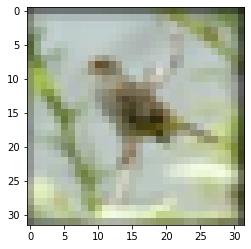

In [14]:

sample = random.choice(range(0,1450))
example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_img[sample:sample+1],
    batch_size=20
    )

plt.imshow(x_train_img[sample]/255.)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [15]:
t = time.perf_counter()

In [16]:
history = model.fit(train_generator, epochs=50, steps_per_epoch=78 , callbacks=[callback_val_loss, callback_val_acc], validation_data = validation_generator, validation_steps=20)

Epoch 1/50
78/78 [==============================] - 51s 546ms/step - loss: 2.2463 - accuracy: 0.1532 - val_loss: 1.7603 - val_accuracy: 0.3602
Epoch 2/50
78/78 [==============================] - 40s 513ms/step - loss: 1.7486 - accuracy: 0.3527 - val_loss: 1.4647 - val_accuracy: 0.4611
Epoch 3/50
78/78 [==============================] - 41s 519ms/step - loss: 1.5293 - accuracy: 0.4376 - val_loss: 1.2827 - val_accuracy: 0.5328
Epoch 4/50
78/78 [==============================] - 40s 514ms/step - loss: 1.3764 - accuracy: 0.5049 - val_loss: 1.1825 - val_accuracy: 0.5723
Epoch 5/50
78/78 [==============================] - 40s 515ms/step - loss: 1.2641 - accuracy: 0.5434 - val_loss: 1.0737 - val_accuracy: 0.6158
Epoch 6/50
78/78 [==============================] - 41s 516ms/step - loss: 1.1896 - accuracy: 0.5756 - val_loss: 1.0426 - val_accuracy: 0.6262
Epoch 7/50
78/78 [==============================] - 41s 518ms/step - loss: 1.1409 - accuracy: 0.5982 - val_loss: 0.9776 - val_accuracy: 0.6484

In [17]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:33:36.272394


## 6. Evaluamos los resultados

In [18]:
_, acc = model.evaluate(x_test_img, y_test_img, verbose=0)
print('Accuracy:',' %.3f' % (acc))

Accuracy:  0.765


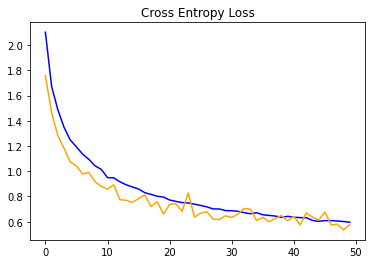

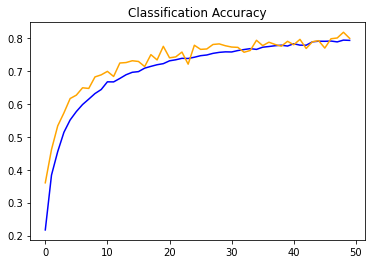

In [19]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [20]:
predictions = model.predict(x_test_img)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [21]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


IndexError: ignored

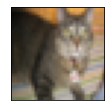

In [22]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test_img, x_test_img)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test_img)
plt.tight_layout()
plt.show()